### Load Library

In [1]:
import pandas as pd
import numpy as np

from string import punctuation, ascii_lowercase, digits
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

from datasets import load_dataset
from sklearn.model_selection import train_test_split


import fasttext
import tempfile
import os

from sklearn.metrics import classification_report
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pickle


### Import Dataset

In [2]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")

train = dataset['train'].to_pandas()
train = train.drop(columns='id')

### Data Wrangling

#### Remove special characters and punctuations

In [3]:
stopwordsSet = set(stopwords.words("english"))

# Create translation table for character filtering once
CHAR_MAP = str.maketrans('', '', punctuation)
VALID_CHARS = set(ascii_lowercase + digits + ' ')

# Compile regex pattern for multiple spaces
SPACE_PATTERN = re.compile(r'\s+')

@lru_cache(maxsize=200000)
def clean_text(content):
    """
    Clean text by converting to lowercase, removing punctuation and stopwords.
    Uses translation tables and caching for better performance.
    """
    # Convert to lowercase
    content = content.lower()
    
    # Remove punctuation using translation table
    content = content.translate(CHAR_MAP)
    
    # Keep only valid characters (faster than checking each character)
    content = ''.join(c for c in content if c in VALID_CHARS)
    
    # Replace multiple spaces with single space and split
    words = SPACE_PATTERN.sub(' ', content).split()
    
    # Filter stopwords
    return ' '.join(w for w in words if w not in stopwordsSet)

def batch_clean_texts(texts, batch_size=20000):
    """
    Clean multiple texts in parallel using batches.
    """
    # Split texts into batches
    batches = np.array_split(texts, max(1, len(texts) // batch_size))
    
    # Process batches in parallel
    with ThreadPoolExecutor() as executor:
        processed_batches = list(executor.map(
            lambda batch: [clean_text(str(text)) for text in batch],
            batches
        ))
    
    # Flatten results
    return [text for batch in processed_batches for text in batch]


In [4]:
train.question_title = batch_clean_texts(train.question_title.values)
train.question_content = batch_clean_texts(train.question_content.values)
train.best_answer = batch_clean_texts(train.best_answer.values)

In [5]:
# Example of website rows
# pd.set_option('display.max_colwidth', None)
selected_rows = train.iloc[6:8]
selected_rows

,topic,question_title,question_content,best_answer
6,1,people blush embarrassed,people blush embarrassed,ask yahoonhttpaskyahoocomask20040113htmlnblush...
7,7,lin qingxia aka brigitte lin beautiful woman c...,according stephen chow httpwwwhkentreviewcom20...,well everyone different definition beauty like...


In [6]:
# Example of mathmatical formula rows
selected_math_rows = train.iloc[15:16]
selected_math_rows[['best_answer']]

,best_answer
15,imaginary numbers numbers squared equal negati...


In [7]:
train

,topic,question_title,question_content,best_answer
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...
3,6,many planes fedex,heard largest airline world,according wwwfedexcom web sitenair fleetbr n b...
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...
...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...
1399998,0,speak hindi,write,main hindi bol sakti hoonkahiye


### Visualize frequent words

In [8]:
# # Words in question title
# question_titles = " ".join(s for s in train.question_title)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [9]:
# # Words in question content
# question_contents = " ".join(s for s in train.question_content)
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [10]:
# # Sample 20% of the words in answers
# sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [11]:
# Create a topic mapping of label and name
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

In [12]:
# check number of records for each topic
topic_counts = train['topic_name'].value_counts()
topic_counts

topic_name
Computers & Internet      140000
Sports                    140000
Health                    140000
Business & Finance        140000
Science & Mathematics     140000
Entertainment & Music     140000
Education & Reference     140000
Family & Relationships    140000
Politics & Government     140000
Society & Culture         140000
Name: count, dtype: int64

### Check Empty Values and Combine Columns

In [13]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        4183
question_content    635515
best_answer          31120
topic_name               0
dtype: int64

In [14]:
# Combine Question title and question content together
combine = train.copy()
combine['question'] = combine['question_title'] + ' ' + combine['question_content']
combine = combine.drop(columns=['question_title', 'question_content'])

In [15]:
combine.head()

,topic,best_answer,topic_name,question
0,4,optical mice use led camera rapidly capture im...,Computers & Internet,doesnt optical mouse work glass table even sur...
1,5,hear mojave road amazingbr nsearch online,Sports,best offroad motorcycle trail longdistance tra...
2,2,trans fats occur manufactured foods process pa...,Health,trans fat reduce heard tras fat bad body find ...
3,6,according wwwfedexcom web sitenair fleetbr n b...,Business & Finance,many planes fedex heard largest airline world
4,6,renting vs buying depends goals br ngenerally ...,Business & Finance,san francisco bay area make sense rent buy pri...


In [16]:
combine.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = combine.isna().sum()
nan_counts

topic              0
best_answer    31120
topic_name         0
question         328
dtype: int64

In [17]:
# drop all NaNs from train dataset
train_clean = combine.dropna().copy()
train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_clean.isna().sum()
nan_counts

topic          0
best_answer    0
topic_name     0
question       0
dtype: int64

In [18]:
train_clean.shape

(1368590, 4)

### Check Duplicates

In [19]:
duplicate_count = train_clean.duplicated(subset=['topic', 'question', 'best_answer']).sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 297


In [20]:
# drop duplicates
train_clean_no_duplicates = train_clean.drop_duplicates(subset=['topic', 'question', 'best_answer']).reset_index(drop=True)

In [21]:
len(train_clean_no_duplicates)

1368293

In [22]:
# check number of records for each topic
topic_counts = train_clean_no_duplicates['topic_name'].value_counts()
topic_counts = pd.DataFrame(topic_counts)

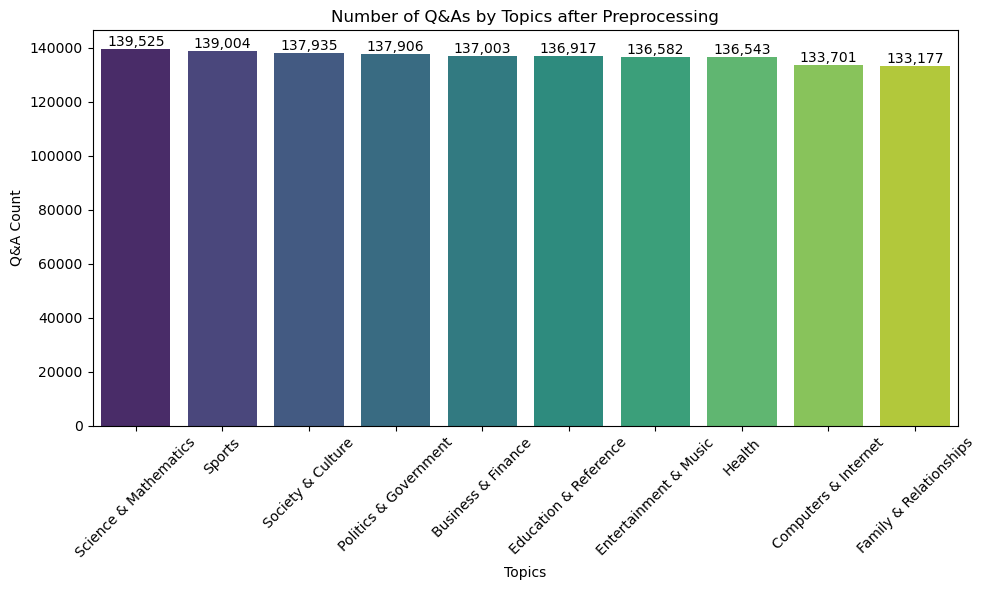

In [23]:
# Plot the total count of Q&As per topic
plt.figure(figsize=(10, 6))
sns.barplot(x='topic_name', y='count', hue='topic_name', data=topic_counts, palette='viridis')

plt.xlabel('Topics')
plt.ylabel('Q&A Count')
plt.title('Number of Q&As by Topics after Preprocessing')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(topic_counts['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Train test split

In [24]:
X = train_clean_no_duplicates.drop(columns=['topic', 'topic_name'])
y = train_clean_no_duplicates['topic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
len(X_train)

1094634

In [26]:
len(y_train)

1094634

In [27]:
len(X_val)

273659

In [28]:
len(y_val)

273659

In [29]:
X_train.head()

,best_answer,question
1170758,play simonsays command wipe nose,proper way let someone talking know booger han...
1238600,figos wife,sexiest wife footballer world cup 2006
707981,liverpool rules,curious ever read team history liverpools 3 tr...
207846,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...
1315775,looks like carolina hurricanes going win 31 se...,win stanley cup


In [30]:
X_val.head()

,best_answer,question
210868,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...
332397,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...
1287631,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...
590830,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...
255960,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling


### FastText Classification


In [31]:
train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_combined = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)


In [32]:
print(len(train_combined))
print(len(val_combined))

1094634
273659


In [33]:
train_combined['category'] = "__label__" + train_combined['topic'].astype(str)
val_combined['category'] = "__label__" + val_combined['topic'].astype(str)


#### FastText Classification using question

In [34]:
train_combined['category_question'] = train_combined['category'] + " " + train_combined['question']
train_combined

,best_answer,question,topic,category,category_question
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup
...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces


In [35]:
val_combined['category_question'] = val_combined['category'] + " " + val_combined['question']
val_combined

,best_answer,question,topic,category,category_question
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...


In [36]:
# save train and validation into txt format
train_combined.to_csv("FastText_question.train",columns=["category_question"],index=False,header=False)
val_combined.to_csv("FastText_question.val",columns=["category_question"],index=False,header=False)


In [37]:
# train fasttext classification model
question_model = fasttext.train_supervised(input="FastText_question.train")
question_model.test("FastText_question.val")

Read 20M words
Number of words:  782272
Number of labels: 10
Progress: 100.0% words/sec/thread: 3553927 lr:  0.000000 avg.loss:  1.012630 ETA:   0h 0m 0s


(273659, 0.7025495233118589, 0.7025495233118589)

In [38]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_question.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [question_model.predict(text)[0][0] for text in validation_data]

In [39]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7025495233118589
Macro Precision: 0.6997556727225834
Macro Recall: 0.7028700659566559
Macro F1-score: 0.7006509115524822


In [40]:
# # Define parameter options
# parameter_options = {
#     "epoch": [5, 10, 15],
#     "lr": [0.1, 0.3, 0.5],
#     "wordNgrams": [1, 2],
#     "dim": [100, 200],
#     "loss": ["softmax", "ova"]
# }


In [41]:
# # Generate all combinations of parameters
# parameter_combinations = list(itertools.product(
#     parameter_options["epoch"],
#     parameter_options["lr"],
#     parameter_options["wordNgrams"],
#     parameter_options["dim"],
#     parameter_options["loss"]
# ))

In [42]:
# results = []

# for params in parameter_combinations:
#     epoch, lr, wordNgrams, dim, loss = params

#     model = fasttext.train_supervised(
#         input="FastText_all.train",
#         epoch=epoch,
#         lr=lr,
#         wordNgrams=wordNgrams,
#         dim=dim,
#         loss=loss
#     )

#     # Predict on validation data
#     predicted_labels = [model.predict(text)[0][0] for text in validation_data]

#     # Compute metrics
#     report = classification_report(true_labels, predicted_labels, output_dict=True)
#     accuracy = report["accuracy"]
#     macro_precision = report["macro avg"]["precision"]
#     macro_recall = report["macro avg"]["recall"]
#     macro_f1 = report["macro avg"]["f1-score"]

#     # Store results
#     results.append({
#         "epoch": epoch,
#         "lr": lr,
#         "wordNgrams": wordNgrams,
#         "dim": dim,
#         "loss": loss,
#         "accuracy": accuracy,
#         "macro_precision": macro_precision,
#         "macro_recall": macro_recall,
#         "macro_f1": macro_f1
#     })

#     print(f"Completed combination: {params}")

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="macro_f1", ascending=False)

In [43]:
# results_df

#### FastText Classification using best_answer

In [44]:
train_combined['category_best_answer'] = train_combined['category'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...
...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people


In [45]:
val_combined['category_best_answer'] = val_combined['category'] + " " + val_combined['best_answer']
val_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...
...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...


In [46]:
# save train and validation into txt format
train_combined.to_csv("FastText_best_answer.train",columns=["category_best_answer"],index=False,header=False)
val_combined.to_csv("FastText_best_answer.val",columns=["category_best_answer"],index=False,header=False)


In [47]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_best_answer.train")
best_answer_model.test("FastText_best_answer.val")

Read 37M words
Number of words:  1698041
Number of labels: 10
Progress: 100.0% words/sec/thread: 4571084 lr:  0.000000 avg.loss:  1.324349 ETA:   0h 0m 0s


(273659, 0.6002031725614725, 0.6002031725614725)

In [48]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_best_answer.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [49]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.6002031725614725
Macro Precision: 0.5996702400322109
Macro Recall: 0.6005913458377585
Macro F1-score: 0.5988610558156708


#### FastText Classification using best_answer and question

In [50]:
train_combined['category_all'] = train_combined['category'] + " " + train_combined['question'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...,__label__5 win stanley cup looks like carolin...
...,...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy,__label__3 alcohol rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people,__label__0 think gays able serve armed forces ...


In [51]:
val_combined['category_all'] = val_combined['category'] + " " + val_combined['question'] + " " + val_combined['best_answer']

val_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...,__label__2 got 8 strands hair left would want ...


In [52]:
# save train and validation into txt format
train_combined.to_csv("FastText_all.train",columns=["category_all"],index=False,header=False)
val_combined.to_csv("FastText_all.val",columns=["category_all"],index=False,header=False)


In [53]:
# train fasttext classification model
all_model = fasttext.train_supervised(input="FastText_all.train")
all_model.test("FastText_all.val")

Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 4683398 lr:  0.000000 avg.loss:  0.952055 ETA:   0h 0m 0s


(273659, 0.7141807870378829, 0.7141807870378829)

In [54]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_all.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [all_model.predict(text)[0][0] for text in validation_data]

In [55]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7141807870378829
Macro Precision: 0.7105739716034007
Macro Recall: 0.7144647950945158
Macro F1-score: 0.7117788825388672


In [56]:
with open("FastText_all.val", "r") as f:
    lines = f.readlines()

true_labels = []
predicted_labels = []

for line in lines:
    label, text = line.split(" ", 1)
    true_labels.append(label)
    predicted_labels.append(all_model.predict(text.strip())[0][0])
print(classification_report(true_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

  __label__0     0.6040    0.5834    0.5935     27587
  __label__1     0.7137    0.7517    0.7322     27905
  __label__2     0.7656    0.7959    0.7805     27309
  __label__3     0.5701    0.5063    0.5363     27384
  __label__4     0.8421    0.8631    0.8525     26740
  __label__5     0.8822    0.8790    0.8806     27801
  __label__6     0.5733    0.5114    0.5406     27401
  __label__7     0.7071    0.7124    0.7098     27316
  __label__8     0.6861    0.7738    0.7273     26635
  __label__9     0.7615    0.7676    0.7645     27581

    accuracy                         0.7142    273659
   macro avg     0.7106    0.7145    0.7118    273659
weighted avg     0.7105    0.7142    0.7116    273659



Epoch 1/30 - Progress: 3.33%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   26940 lr:  0.000000 avg.loss:  1.144947 ETA:   0h 0m 0s 37.7% words/sec/thread:   21422 lr:  0.186822 avg.loss:  1.300550 ETA:   0h 3m48s 54.7% words/sec/thread:   26511 lr:  0.135769 avg.loss:  1.229590 ETA:   0h 2m13s 58.5% words/sec/thread:   27430 lr:  0.124531 avg.loss:  1.216487 ETA:   0h 1m58s 68.0% words/sec/thread:   29337 lr:  0.096055 avg.loss:  1.194486 ETA:   0h 1m25s 68.8% words/sec/thread:   29403 lr:  0.093627 avg.loss:  1.192592 ETA:   0h 1m23s 73.3% words/sec/thread:   30455 lr:  0.080076 avg.loss:  1.185690 ETA:   0h 1m 8s 78.8% words/sec/thread:   30046 lr:  0.063472 avg.loss:  1.174752 ETA:   0h 0m55s


Epoch 1: Train Loss = 0.2753, Validation Loss = 0.2872, Macro F1 = 0.7096
New best model saved with Macro F1 = 0.7096
Epoch 2/30 - Progress: 6.67%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   39138 lr:  0.000000 avg.loss:  1.053725 ETA:   0h 0m 0s 29.7% words/sec/thread:   18632 lr:  0.210777 avg.loss:  1.216887 ETA:   0h 9m51s 40.8% words/sec/thread:   23444 lr:  0.177686 avg.loss:  1.173906 ETA:   0h 6m36s 58.5% words/sec/thread:   28870 lr:  0.124576 avg.loss:  1.128969 ETA:   0h 3m45s 3m38s 63.2% words/sec/thread:   30080 lr:  0.110295 avg.loss:  1.115695 ETA:   0h 3m11s 64.0% words/sec/thread:   30285 lr:  0.108102 avg.loss:  1.113910 ETA:   0h 3m 6s 66.7% words/sec/thread:   31048 lr:  0.099879 avg.loss:  1.106678 ETA:   0h 2m48s 82.3% words/sec/thread:   34802 lr:  0.053227 avg.loss:  1.078166 ETA:   0h 1m19s 85.4% words/sec/thread:   35607 lr:  0.043709 avg.loss:  1.072945 ETA:   0h 1m 4s


Epoch 2: Train Loss = 0.2612, Validation Loss = 0.2818, Macro F1 = 0.7151
New best model saved with Macro F1 = 0.7151
Epoch 3/30 - Progress: 10.00%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   50058 lr:  0.000000 avg.loss:  1.009897 ETA:   0h 0m 0s  24311 lr:  0.255771 avg.loss:  1.271024 ETA:   0h13m45s 25.2% words/sec/thread:   29220 lr:  0.224449 avg.loss:  1.185884 ETA:   0h10m 2s 27.5% words/sec/thread:   30005 lr:  0.217550 avg.loss:  1.174056 ETA:   0h 9m28s 39.7% words/sec/thread:   34176 lr:  0.180884 avg.loss:  1.130376 ETA:   0h 6m55s 44.2% words/sec/thread:   34951 lr:  0.167462 avg.loss:  1.112931 ETA:   0h 6m15s 44.6% words/sec/thread:   34927 lr:  0.166246 avg.loss:  1.111821 ETA:   0h 6m13s  37384 lr:  0.147427 avg.loss:  1.093707 ETA:   0h 5m 9s 59.9% words/sec/thread:   40567 lr:  0.120286 avg.loss:  1.073715 ETA:   0h 3m52s 61.0% words/sec/thread:   40953 lr:  0.116942 avg.loss:  1.072394 ETA:   0h 3m43s% words/sec/thread:   43200 lr:  0.090271 avg.loss:  1.056474 ETA:   0h 2m43s 69.9% words/sec/thread:   43177 lr:  0.090268 avg.loss:  1.056474 ETA:   0h 2m44

Epoch 3: Train Loss = 0.2508, Validation Loss = 0.2803, Macro F1 = 0.7169
New best model saved with Macro F1 = 0.7169
Epoch 4/30 - Progress: 13.33%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   63514 lr:  0.000000 avg.loss:  0.978229 ETA:   0h 0m 0s 10.5% words/sec/thread:   30835 lr:  0.268396 avg.loss:  1.280120 ETA:   0h15m10s 11.0% words/sec/thread:   31546 lr:  0.266973 avg.loss:  1.271038 ETA:   0h14m45s 12.5% words/sec/thread:   33168 lr:  0.262621 avg.loss:  1.247888 ETA:   0h13m48s 45.2% words/sec/thread:   55019 lr:  0.164463 avg.loss:  1.076318 ETA:   0h 5m12s 61.3% words/sec/thread:   56666 lr:  0.116011 avg.loss:  1.037148 ETA:   0h 3m34s 62.7% words/sec/thread:   56987 lr:  0.111859 avg.loss:  1.034794 ETA:   0h 3m25s 75.9% words/sec/thread:   60214 lr:  0.072213 avg.loss:  1.014747 ETA:   0h 2m 5s 76.6% words/sec/thread:   59919 lr:  0.070096 avg.loss:  1.013623 ETA:   0h 2m 2s 82.2% words/sec/thread:   59687 lr:  0.053454 avg.loss:  1.004182 ETA:   0h 1m33s 83.0% words/sec/thread:   59570 lr:  0.051096 avg.loss:  1.002615 ETA:   0h 1m29s 84.1% words/sec/thread:  

Epoch 4: Train Loss = 0.2410, Validation Loss = 0.2796, Macro F1 = 0.7178
New best model saved with Macro F1 = 0.7178
Epoch 5/30 - Progress: 16.67%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   60647 lr:  0.000000 avg.loss:  0.951154 ETA:   0h 0m 0s 16.0% words/sec/thread:   44051 lr:  0.251892 avg.loss:  1.177262 ETA:   0h12m27s 18.3% words/sec/thread:   45329 lr:  0.245072 avg.loss:  1.162161 ETA:   0h11m46s 26.3% words/sec/thread:   51973 lr:  0.221229 avg.loss:  1.115471 ETA:   0h 9m16s 37.2% words/sec/thread:   57969 lr:  0.188458 avg.loss:  1.074709 ETA:   0h 7m 5s 51.7% words/sec/thread:   61732 lr:  0.144848 avg.loss:  1.033690 ETA:   0h 5m 6s0.137824 avg.loss:  1.028861 ETA:   0h 4m54s 64.7% words/sec/thread:   60846 lr:  0.105763 avg.loss:  1.010097 ETA:   0h 3m47s 67.7% words/sec/thread:   60459 lr:  0.096929 avg.loss:  1.004117 ETA:   0h 3m29s 73.1% words/sec/thread:   59504 lr:  0.080706 avg.loss:  0.994384 ETA:   0h 2m57s 76.2% words/sec/thread:   59453 lr:  0.071376 avg.loss:  0.989120 ETA:   0h 2m36s 84.4% words/sec/thread:   59503 lr:  0.046866 avg.loss:  0.9755

Epoch 5: Train Loss = 0.2314, Validation Loss = 0.2799, Macro F1 = 0.7176
No improvement for 1 epoch(s)
Epoch 6/30 - Progress: 20.00%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   50271 lr:  0.000000 avg.loss:  0.928643 ETA:   0h 0m 0s  0.3% words/sec/thread:   23258 lr:  0.299212 avg.loss:  2.306514 ETA:   0h33m38s  1.8% words/sec/thread:   26487 lr:  0.294460 avg.loss:  1.682579 ETA:   0h29m 4s  4.1% words/sec/thread:   24881 lr:  0.287771 avg.loss:  1.403168 ETA:   0h30m14s  4.1% words/sec/thread:   24817 lr:  0.287768 avg.loss:  1.403102 ETA:   0h30m19s  4.7% words/sec/thread:   22026 lr:  0.285830 avg.loss:  1.366695 ETA:   0h33m55s  5.7% words/sec/thread:   21026 lr:  0.283025 avg.loss:  1.324467 ETA:   0h35m11s 11.8% words/sec/thread:   23636 lr:  0.264690 avg.loss:  1.195693 ETA:   0h29m16s 14.0% words/sec/thread:   24913 lr:  0.257975 avg.loss:  1.175301 ETA:   0h27m 4s 15.7% words/sec/thread:   26699 lr:  0.252938 avg.loss:  1.162807 ETA:   0h24m46s19m15s 28.7% words/sec/thread:   34785 lr:  0.213792 avg.loss:  1.085096 ETA:   0h16m 4s 33.7% words/sec/thr

Epoch 6: Train Loss = 0.2213, Validation Loss = 0.2807, Macro F1 = 0.7170
No improvement for 2 epoch(s)
Epoch 7/30 - Progress: 23.33%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   21146 lr:  0.000000 avg.loss:  0.905317 ETA:   0h 0m 0s 10.6% words/sec/thread:   19213 lr:  0.268172 avg.loss:  1.188962 ETA:   0h42m34sm46s avg.loss:  1.152085 ETA:   0h40m42s 21.8% words/sec/thread:   19425 lr:  0.234507 avg.loss:  1.096684 ETA:   0h36m49s 24.2% words/sec/thread:   19698 lr:  0.227331 avg.loss:  1.085525 ETA:   0h35m12s 25.9% words/sec/thread:   20008 lr:  0.222151 avg.loss:  1.078493 ETA:   0h33m52s 26.8% words/sec/thread:   20427 lr:  0.219691 avg.loss:  1.075290 ETA:   0h32m48s 29.6% words/sec/thread:   21315 lr:  0.211292 avg.loss:  1.065336 ETA:   0h30m14s 0.204614 avg.loss:  1.054861 ETA:   0h28m59s 45.1% words/sec/thread:   21155 lr:  0.164819 avg.loss:  1.016846 ETA:   0h23m46s 48.4% words/sec/thread:   21320 lr:  0.154940 avg.loss:  1.007666 ETA:   0h22m10s 52.9% words/sec/thread:   21205 lr:  0.141268 avg.loss:  0.997629 ETA:   0h20m19s 0.132934 avg.loss:  0.

Epoch 7: Train Loss = 0.2106, Validation Loss = 0.2819, Macro F1 = 0.7158
No improvement for 3 epoch(s)
Epoch 8/30 - Progress: 26.67%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   23829 lr:  0.000000 avg.loss:  0.884576 ETA:   0h 0m 0ss 10.9% words/sec/thread:   25259 lr:  0.267396 avg.loss:  1.169363 ETA:   0h36m54sh36m 0s ETA:   0h33m 5s% words/sec/thread:   23153 lr:  0.220017 avg.loss:  1.061489 ETA:   0h33m 7s 27.2% words/sec/thread:   22984 lr:  0.218254 avg.loss:  1.058320 ETA:   0h33m 6s 29.2% words/sec/thread:   22839 lr:  0.212435 avg.loss:  1.048887 ETA:   0h32m25s 30.7% words/sec/thread:   22823 lr:  0.208017 avg.loss:  1.042942 ETA:   0h31m46s 34.2% words/sec/thread:   22688 lr:  0.197459 avg.loss:  1.031181 ETA:   0h30m20s 39.9% words/sec/thread:   22576 lr:  0.180386 avg.loss:  1.017039 ETA:   0h27m51s  0h25m 2s 49.4% words/sec/thread:   22003 lr:  0.151911 avg.loss:  0.992295 ETA:   0h24m 4s 54.5% words/sec/thread:   22365 lr:  0.136483 avg.loss:  0.979226 ETA:   0h21m16s ETA:   0h21m15s 56.5% words/sec/thread:   22589 lr:  0.130372 avg.loss:  0.974

Epoch 8: Train Loss = 0.1997, Validation Loss = 0.2827, Macro F1 = 0.7151
No improvement for 4 epoch(s)
Epoch 9/30 - Progress: 30.00%


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread:   19988 lr:  0.000000 avg.loss:  0.862889 ETA:   0h 0m 0s  21677 lr:  0.298430 avg.loss:  2.126940 ETA:   0h53m59s  0h56m32s  9.9% words/sec/thread:   20323 lr:  0.270192 avg.loss:  1.165164 ETA:   0h52m 8s 58.6% words/sec/thread:   20023 lr:  0.124051 avg.loss:  0.955876 ETA:   0h24m17s 0.121490 avg.loss:  0.953809 ETA:   0h23m47s 73.4% words/sec/thread:   20070 lr:  0.079787 avg.loss:  0.922806 ETA:   0h15m35s 78.9% words/sec/thread:   19904 lr:  0.063296 avg.loss:  0.911623 ETA:   0h12m28s 84.4% words/sec/thread:   19988 lr:  0.046755 avg.loss:  0.898551 ETA:   0h 9m10s 98.9% words/sec/thread:   19986 lr:  0.003348 avg.loss:  0.865283 ETA:   0h 0m39s


Epoch 9: Train Loss = 0.1883, Validation Loss = 0.2846, Macro F1 = 0.7134
No improvement for 5 epoch(s)
Early stopping triggered after 9 epochs!


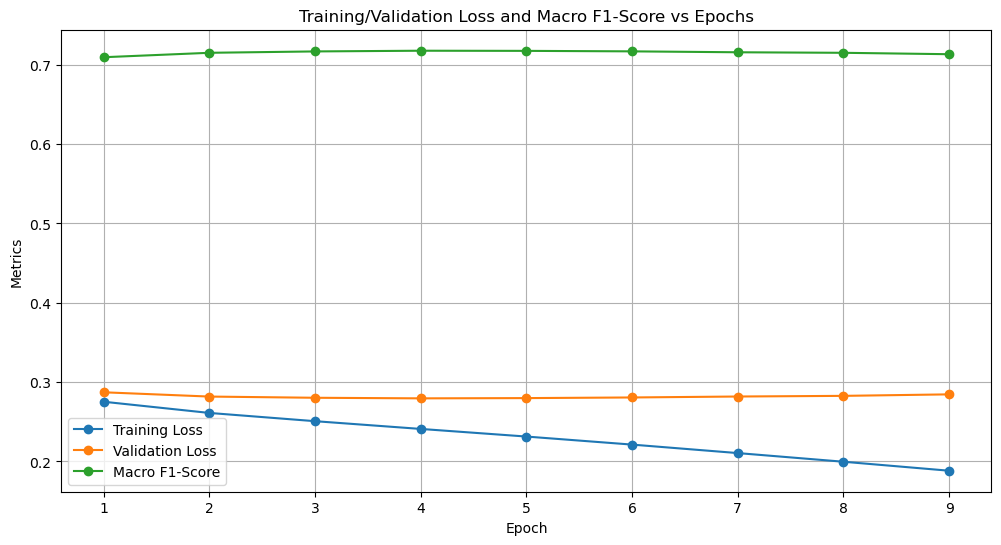


Final Metrics:
Accuracy: 0.7204404021062709
Macro Precision: 0.7164815696250553
Macro Recall: 0.7206934476501984
Macro F1-score: 0.7177554491828569

Full Classification Report:
              precision    recall  f1-score   support

  __label__0     0.6023    0.5921    0.5971     27587
  __label__1     0.7175    0.7639    0.7400     27905
  __label__2     0.7704    0.8038    0.7867     27309
  __label__3     0.5696    0.5137    0.5402     27384
  __label__4     0.8447    0.8715    0.8579     26740
  __label__5     0.8826    0.8854    0.8840     27801
  __label__6     0.5992    0.5083    0.5500     27401
  __label__7     0.7129    0.7175    0.7152     27316
  __label__8     0.7007    0.7726    0.7349     26635
  __label__9     0.7650    0.7780    0.7715     27581

    accuracy                         0.7204    273659
   macro avg     0.7165    0.7207    0.7178    273659
weighted avg     0.7164    0.7204    0.7176    273659



In [57]:
# Paths to your datasets
train_file = "FastText_all.train"
val_file = "FastText_all.val"

# Initialize lists to track losses and macro F1 scores
train_losses = []
val_losses = []
macro_f1_scores = []
epochs = 30  # Maximum number of epochs
patience = 5  # Early stopping patience (number of epochs without improvement)
best_f1 = 0.0  # Best macro F1 score
no_improve_epochs = 0  # Counter for epochs without improvement
model_save_path = "best_answer_model.bin"  # Path to save the model

# Early stopping loop
for epoch in range(1, epochs + 1):
    # Display progress percentage
    progress = (epoch / epochs) * 100
    print(f"Epoch {epoch}/{epochs} - Progress: {progress:.2f}%")
    # Train the model for the current epoch
    model = fasttext.train_supervised(input=train_file, 
                                      epoch=epoch, 
                                      lr=0.3, 
                                      wordNgrams=2, 
                                      dim=300,
                                      minn=3,                 # Minimum character n-gram size
                                      maxn=6,                 # Maximum character n-gram size
                                      bucket=5000000,         # Large hash bucket size
                                      loss='softmax')
    
    # Evaluate on the training set
    train_results = model.test(train_file)
    train_loss = 1 - train_results[1]  # Approximate training loss as (1 - precision)
    train_losses.append(train_loss)
    
    # Evaluate on the validation set
    val_results = model.test(val_file)
    val_loss = 1 - val_results[1]  # Approximate validation loss as (1 - precision)
    val_losses.append(val_loss)
    
    # Prepare validation data for detailed evaluation
    validation_data = []
    true_labels = []
    with open(val_file, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            true_labels.append(parts[0])  # Extract true label
            validation_data.append(parts[1])  # Extract text
    
    # Predict using the model
    predicted_labels = [model.predict(text)[0][0] for text in validation_data]
    
    # Generate classification report
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    macro_f1_scores.append(macro_f1)
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, Macro F1 = {macro_f1:.4f}")
    
    # Check for early stopping
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        no_improve_epochs = 0
        # Save the best model
        model.save_model(model_save_path)
        print(f"New best model saved with Macro F1 = {macro_f1:.4f}")
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epoch(s)")
    
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch} epochs!")
        break

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.plot(range(1, len(macro_f1_scores) + 1), macro_f1_scores, label="Macro F1-Score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Training/Validation Loss and Macro F1-Score vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Evaluate the final model (best saved model) on the full validation set
final_model = fasttext.load_model(model_save_path)
validation_data = []
true_labels = []
with open(val_file, "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  # Extract true label
        validation_data.append(parts[1])  # Extract text

# Predict using the final model
predicted_labels = [final_model.predict(text)[0][0] for text in validation_data]

# Generate final classification report
final_report = classification_report(true_labels, predicted_labels, digits=4, output_dict=True)
accuracy = final_report["accuracy"]
macro_precision = final_report["macro avg"]["precision"]
macro_recall = final_report["macro avg"]["recall"]
macro_f1 = final_report["macro avg"]["f1-score"]

print("\nFinal Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}\n")

print("Full Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

### FastText as word Embedding

In [57]:
X_train.head()

,best_answer,question
1170758,play simonsays command wipe nose,proper way let someone talking know booger han...
1238600,figos wife,sexiest wife footballer world cup 2006
707981,liverpool rules,curious ever read team history liverpools 3 tr...
207846,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...
1315775,looks like carolina hurricanes going win 31 se...,win stanley cup


In [58]:
# save train and validation into txt format
X_train.to_csv("FastText_question_emd.train",columns=["question"],index=False,header=False)
X_val.to_csv("FastText_question_emd.val",columns=["question"],index=False,header=False)

In [79]:
X_train_all = X_train.copy()
X_val_all = X_val.copy()

X_train_all['question_answer'] = X_train_all['question'] + " " + X_train_all['best_answer']
X_val_all['question_answer'] = X_val_all['question'] + " " + X_val_all['best_answer']

In [80]:
# save train and validation into txt format
X_train_all.to_csv("FastText_all_emd.train",columns=["question_answer"],index=False,header=False)
X_val_all.to_csv("FastText_all_emd.val",columns=["question_answer"],index=False,header=False)

#### FastText Embedding Questions

In [59]:
X_train_question = X_train[['question']]
X_val_question = X_val[['question']]

In [60]:
train_labels = y_train.copy()
val_labels = y_val.copy()

In [61]:
# Train FastText to generate word embeddings
# question_emd_model = fasttext.train_unsupervised("FastText_question_emd.train", model="skipgram")

Read 18M words
Number of words:  84510
Number of labels: 0
Progress: 100.0% words/sec/thread:  116733 lr:  0.000000 avg.loss:  1.556216 ETA:   0h 0m 0s


In [62]:
# all words in the vocabulary, sorted by decreasing frequency
# question_emd_model.words

['</s>',
 'know',
 'like',
 'get',
 'would',
 'im',
 'dont',
 'think',
 'help',
 'one',
 'want',
 'need',
 'people',
 'anyone',
 'really',
 'please',
 'good',
 'find',
 'go',
 'time',
 'make',
 'best',
 'u',
 'tell',
 'love',
 'cant',
 'way',
 'many',
 'much',
 'could',
 'work',
 '2',
 'someone',
 'us',
 'say',
 'going',
 'back',
 'see',
 'years',
 'question',
 'give',
 'still',
 'world',
 'take',
 'new',
 'also',
 'something',
 'use',
 'even',
 'name',
 'mean',
 'year',
 'got',
 'right',
 'feel',
 'old',
 'guy',
 'first',
 'answer',
 'day',
 'school',
 'whats',
 'said',
 'ever',
 'ive',
 'friend',
 'life',
 'looking',
 'girl',
 'never',
 'god',
 'person',
 'computer',
 'anything',
 'two',
 'come',
 'long',
 'better',
 'always',
 'things',
 'last',
 'friends',
 'free',
 'home',
 'man',
 'money',
 'thing',
 'well',
 '3',
 'bad',
 'doesnt',
 'told',
 'without',
 'song',
 'says',
 'live',
 'getting',
 'sex',
 'thanks',
 '1',
 'yahoo',
 'guys',
 'problem',
 'job',
 'put',
 'look',
 'anothe

In [63]:
# word vector
# question_emd_model.get_word_vector("know")

array([-6.43789470e-02,  9.76730064e-02, -3.38787735e-01,  1.81162640e-01,
       -5.47218770e-02, -1.33592322e-01,  5.24733309e-03, -2.07850456e-01,
        2.19691157e-01, -4.35375385e-02, -9.75479484e-02,  9.89491940e-02,
        3.25755239e-01,  1.48209557e-01, -3.04147333e-01, -1.51590794e-01,
        6.72664791e-02, -1.27852291e-01,  2.11626127e-01, -2.41880685e-01,
        8.88031349e-02,  6.17403351e-03,  1.22543275e-01, -5.88736637e-03,
        1.49349973e-01, -1.74789280e-02,  1.41772807e-01,  2.54044652e-01,
       -1.93168387e-01,  1.61542088e-01,  6.67951852e-02,  1.47633016e-01,
       -1.34572238e-01, -2.17558935e-01, -1.01409480e-01,  5.23222163e-02,
        2.05832094e-01, -1.26720101e-01, -1.58366337e-01,  3.63546044e-01,
        1.10667318e-01,  5.86851537e-02,  1.66022137e-01, -1.83452263e-01,
        2.04669699e-01, -4.86924388e-02, -7.27160648e-02, -5.38600311e-02,
       -1.88180342e-01,  4.68604192e-02, -9.01376754e-02,  1.62757888e-01,
       -9.01163518e-02,  

In [64]:
# save model
# question_emd_model.save_model("question_emd_model.bin")
# load model
question_emd_model = fasttext.load_model("question_emd_model.bin")


In [65]:
X_train_question_list = X_train_question['question'].tolist()
X_val_question_list = X_val_question['question'].tolist()

In [66]:
# def get_sentence_embedding(sentence, model):
#     """
#     Generate sentence embedding by averaging word vectors.
#     """
#     words = sentence.split()
#     word_vectors = [model[word] for word in words if word in model]
#     return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.get_dimension())

# # Step 3: Prepare training and validation data
# # Assume `train_texts`, `val_texts`, `train_labels`, and `val_labels` are preloaded lists
# # Convert texts to embeddings
# X_train_question_emd = np.array([get_sentence_embedding(text, question_emd_model) for text in X_train_question_list])
# X_val_question_emd = np.array([get_sentence_embedding(text, question_emd_model) for text in X_val_question_list])

In [67]:
# X_train_question_emd.shape

In [68]:
# X_val_question_emd.shape

In [69]:

# X_train_question_emd_df = pd.DataFrame(X_train_question_emd)
# X_val_question_emd_df = pd.DataFrame(X_val_question_emd)

# # Save as CSV files
# X_train_question_emd_df.to_csv('question_train_emd.csv', index=False)
# X_val_question_emd_df.to_csv('question_val_emd.csv', index=False)

# To load the data back into NumPy arrays
X_train_question_emd = pd.read_csv('question_train_emd.csv').values
X_val_question_emd = pd.read_csv('question_val_emd.csv').values

In [70]:
# For Naive Bayes (requires sparse data like TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_question_list)
X_val_tfidf = tfidf_vectorizer.transform(X_val_question_list)

In [75]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel='linear', probability=True)
}

In [76]:
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == "Naive Bayes (TF-IDF)":
        # Train using TF-IDF features
        model.fit(X_train_tfidf, train_labels)
        preds = model.predict(X_val_tfidf)
    else:
        # Train using embeddings
        model.fit(X_train_question_emd, train_labels)
        preds = model.predict(X_val_question_emd)

    # Evaluate model
    report = classification_report(val_labels, preds, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-score": macro_f1
    })

    print(f"Completed {model_name}")

# Step 6: Display and compare results
results_df = pd.DataFrame(results).sort_values(by="Macro F1-score", ascending=False)

Training Logistic Regression...
Completed Logistic Regression
Training Random Forest...
Completed Random Forest


In [77]:
results_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score
1,Random Forest,0.684578,0.679819,0.684925,0.680601
0,Logistic Regression,0.675651,0.671499,0.676141,0.672279


#### FastText Embedding Question and Best Answer


In [81]:
X_train_all = X_train_all[['question_answer']]
X_val_all = X_val_all[['question_answer']]

In [82]:
train_labels = y_train.copy()
val_labels = y_val.copy()

In [83]:
# Train FastText to generate word embeddings
all_emd_model = fasttext.train_unsupervised("FastText_all_emd.train", model="skipgram")

Read 53M words
Number of words:  194484
Number of labels: 0
Progress: 100.0% words/sec/thread:   85000 lr:  0.000000 avg.loss:  0.688194 ETA:   0h 0m 0s


In [ ]:
# all words in the vocabulary, sorted by decreasing frequency
# question_emd_model.words

['</s>',
 'know',
 'like',
 'get',
 'would',
 'im',
 'dont',
 'think',
 'help',
 'one',
 'want',
 'need',
 'people',
 'anyone',
 'really',
 'please',
 'good',
 'find',
 'go',
 'time',
 'make',
 'best',
 'u',
 'tell',
 'love',
 'cant',
 'way',
 'many',
 'much',
 'could',
 'work',
 '2',
 'someone',
 'us',
 'say',
 'going',
 'back',
 'see',
 'years',
 'question',
 'give',
 'still',
 'world',
 'take',
 'new',
 'also',
 'something',
 'use',
 'even',
 'name',
 'mean',
 'year',
 'got',
 'right',
 'feel',
 'old',
 'guy',
 'first',
 'answer',
 'day',
 'school',
 'whats',
 'said',
 'ever',
 'ive',
 'friend',
 'life',
 'looking',
 'girl',
 'never',
 'god',
 'person',
 'computer',
 'anything',
 'two',
 'come',
 'long',
 'better',
 'always',
 'things',
 'last',
 'friends',
 'free',
 'home',
 'man',
 'money',
 'thing',
 'well',
 '3',
 'bad',
 'doesnt',
 'told',
 'without',
 'song',
 'says',
 'live',
 'getting',
 'sex',
 'thanks',
 '1',
 'yahoo',
 'guys',
 'problem',
 'job',
 'put',
 'look',
 'anothe

In [ ]:
# word vector
# question_emd_model.get_word_vector("know")

array([-6.43789470e-02,  9.76730064e-02, -3.38787735e-01,  1.81162640e-01,
       -5.47218770e-02, -1.33592322e-01,  5.24733309e-03, -2.07850456e-01,
        2.19691157e-01, -4.35375385e-02, -9.75479484e-02,  9.89491940e-02,
        3.25755239e-01,  1.48209557e-01, -3.04147333e-01, -1.51590794e-01,
        6.72664791e-02, -1.27852291e-01,  2.11626127e-01, -2.41880685e-01,
        8.88031349e-02,  6.17403351e-03,  1.22543275e-01, -5.88736637e-03,
        1.49349973e-01, -1.74789280e-02,  1.41772807e-01,  2.54044652e-01,
       -1.93168387e-01,  1.61542088e-01,  6.67951852e-02,  1.47633016e-01,
       -1.34572238e-01, -2.17558935e-01, -1.01409480e-01,  5.23222163e-02,
        2.05832094e-01, -1.26720101e-01, -1.58366337e-01,  3.63546044e-01,
        1.10667318e-01,  5.86851537e-02,  1.66022137e-01, -1.83452263e-01,
        2.04669699e-01, -4.86924388e-02, -7.27160648e-02, -5.38600311e-02,
       -1.88180342e-01,  4.68604192e-02, -9.01376754e-02,  1.62757888e-01,
       -9.01163518e-02,  

In [84]:
# save model
all_emd_model.save_model("all_emd_model.bin")
# load model
# question_emd_model = fasttext.load_model("question_emd_model.bin")


In [85]:
X_train_all_list = X_train_all['question_answer'].tolist()
X_val_all_list = X_val_all['question_answer'].tolist()

In [86]:
def get_sentence_embedding(sentence, model):
    """
    Generate sentence embedding by averaging word vectors.
    """
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.get_dimension())


X_train_all_emd = np.array([get_sentence_embedding(text, all_emd_model) for text in X_train_all_list])
X_val_all_emd = np.array([get_sentence_embedding(text, all_emd_model) for text in X_val_all_list])

In [87]:
X_train_all_emd.shape

(1094634, 100)

In [88]:
X_val_all_emd.shape

(273659, 100)

In [89]:

X_train_all_emd_df = pd.DataFrame(X_train_all_emd)
X_val_all_emd_df = pd.DataFrame(X_val_all_emd)

# Save as CSV files
X_train_all_emd_df.to_csv('all_train_emd.csv', index=False)
X_val_all_emd_df.to_csv('all_val_emd.csv', index=False)

# # To load the data back into NumPy arrays
# X_train_all_emd = pd.read_csv('all_train_emd.csv').values
# X_val_all_emd = pd.read_csv('all_val_emd.csv').values

In [90]:
# For Naive Bayes (requires sparse data like TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_all = tfidf_vectorizer.fit_transform(X_train_all_list)
X_val_tfidf_all = tfidf_vectorizer.transform(X_val_all_list)

In [91]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel='linear', probability=True)
}

In [95]:
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == "Naive Bayes (TF-IDF)":
        # Train using TF-IDF features
        model.fit(X_train_tfidf_all, train_labels)
        preds = model.predict(X_val_tfidf_all)
    else:
        # Train using embeddings
        model.fit(X_train_all_emd, train_labels)
        preds = model.predict(X_val_all_emd)
    
    # Save the trained model
    model_filename = f"all_emd_{model_name.replace(' ', '_')}.bin"  # Replace spaces to avoid filename issues
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)  # Use pickle to save the model
    print(f"Model saved as {model_filename}")


    # Evaluate model
    report = classification_report(val_labels, preds, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-score": macro_f1
    })

    print(f"Completed {model_name}")

# Step 6: Display and compare results
emd_all_results_df = pd.DataFrame(results).sort_values(by="Macro F1-score", ascending=False)

# load the model
# with open("all_emd_ModelName.bin", "rb") as f:
#     model = pickle.load(f)

Training Logistic Regression...
Model saved as all_emd_Logistic_Regression.bin
Completed Logistic Regression
Training Naive Bayes (TF-IDF)...
Model saved as all_emd_Naive_Bayes_(TF-IDF).bin
Completed Naive Bayes (TF-IDF)
Training Random Forest...
Model saved as all_emd_Random_Forest.bin
Completed Random Forest


In [96]:
emd_all_results_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score
2,Random Forest,0.700686,0.695850,0.700981,0.696654
0,Logistic Regression,0.697715,0.693313,0.698086,0.694293
1,Naive Bayes (TF-IDF),0.663274,0.660860,0.663874,0.659989


In [97]:
emd_all_results_df.to_csv('emd_all_results.csv')